<a href="https://colab.research.google.com/github/female-coders-linz/workshops/blob/master/workshops/time_series/forecasting_prophet_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting with Prophet

In [0]:
# Install mwviews (needed to access Wikipedia article views data)
from IPython.display import clear_output

!pip install mwviews

clear_output()

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

from fbprophet import Prophet
from mwviews.api import PageviewsClient
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
# Load data: page views of wikipedia site
p = PageviewsClient(user_agent="info@female-coders.at Prophet time series forecasting example")

# go back to 20150701
article_views = p.article_views('en.wikipedia', ['Wolfgang Amadeus Mozart', 'Austria'], granularity='monthly', start='20150701', end='20200430' )
df_article_views = pd.DataFrame(article_views).T.sort_index()
df_article_views.head()

,Wolfgang_Amadeus_Mozart,Austria
2015-07-01,181376,218090
2015-08-01,202568,226018
2015-09-01,249539,279892
2015-10-01,246551,215564
2015-11-01,264078,220927


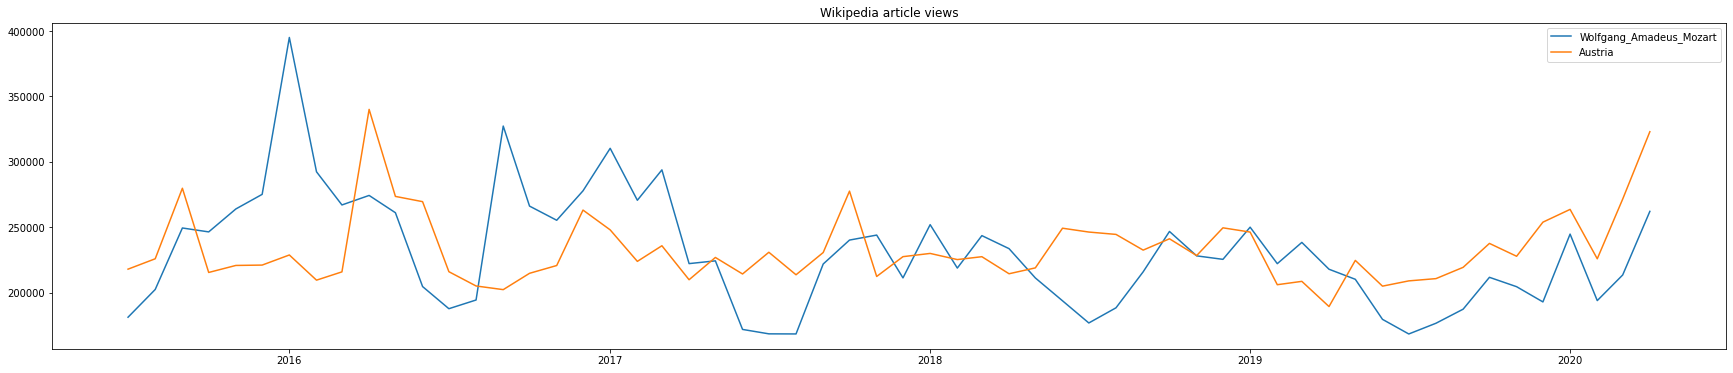

In [4]:
# First view on the data

fig = plt.figure(figsize=(30, 6))
plt.plot(df_article_views)
plt.legend(df_article_views.columns)
plt.title('Wikipedia article views')
plt.show()

## Prepare dataframe

In [0]:
# let's use Wolfgang Amadeus Mozart 
# input data needs column ds (time) and y 
df_input = pd.DataFrame({ 
    'ds': df_article_views.index, 
    'y': df_article_views['Wolfgang_Amadeus_Mozart']
})


In [6]:
# Define what data we want to use for training and test

test_len = 6
train, test = df_input[:-test_len], df_input[-test_len:]

print(f'Training size: {len(train)}')
print(f'Test size: {test_len}')

Training size: 52
Test size: 6


In [9]:
# Fit model

# if you have daily data, you might want to include holidays, 
#    e.g. birthday, Salzburger Festspiele,...

# mozart_birthday = pd.DataFrame({
#   'holiday': 'mozart_birthday',
#   'ds': pd.to_datetime(['2018-01-27', '2019-01-27', '2020-01-27']),
#   'lower_window': 0,
#   'upper_window': 1,
# })

model = Prophet( 
      interval_width=0.95, 
      seasonality_prior_scale=0.025,
      #holidays=mozart_birthday,
)

model.fit(train)

# if you are more interested in the tech details, have a look at the parameters
# model.params

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [10]:
# Create a 'future' dataframe 
df_future = model.make_future_dataframe(periods=test_len, freq = 'M')
df_future.tail()

,ds
53,2019-11-30
54,2019-12-31
55,2020-01-31
56,2020-02-29
57,2020-03-31


In [11]:
# predict the future
df_forecast = model.predict(df_future)
df_forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
53,2019-11-30,198134.687866,162650.323393,251077.920124,198134.677022,198134.695960,8009.778687,8009.778687,8009.778687,8009.778687,8009.778687,8009.778687,0.0,0.0,0.0,206144.466552
54,2019-12-31,196826.500177,214414.400197,299814.719040,196826.481735,196826.518030,57944.424287,57944.424287,57944.424287,57944.424287,57944.424287,57944.424287,0.0,0.0,0.0,254770.924464
55,2020-01-31,195518.312488,165616.763165,249269.979486,195518.285798,195518.339278,12023.886330,12023.886330,12023.886330,12023.886330,12023.886330,12023.886330,0.0,0.0,0.0,207542.198818
56,2020-02-29,194294.524005,175583.866256,263219.988076,194294.487868,194294.559000,24702.306077,24702.306077,24702.306077,24702.306077,24702.306077,24702.306077,0.0,0.0,0.0,218996.830082
57,2020-03-31,192986.336317,155504.114192,240484.659574,192986.288543,192986.382546,5572.354055,5572.354055,5572.354055,5572.354055,5572.354055,5572.354055,0.0,0.0,0.0,198558.690372


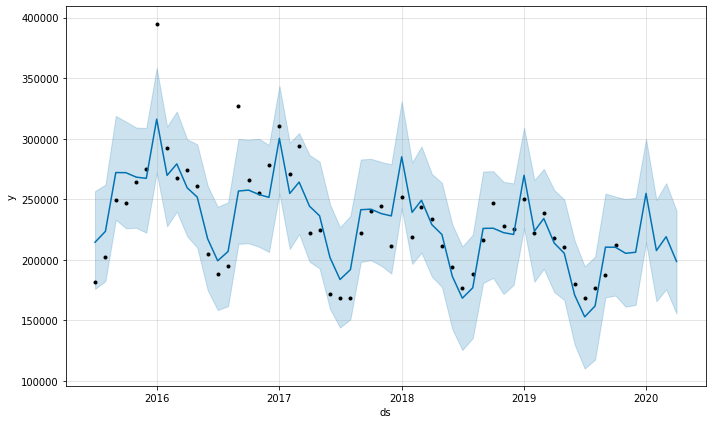

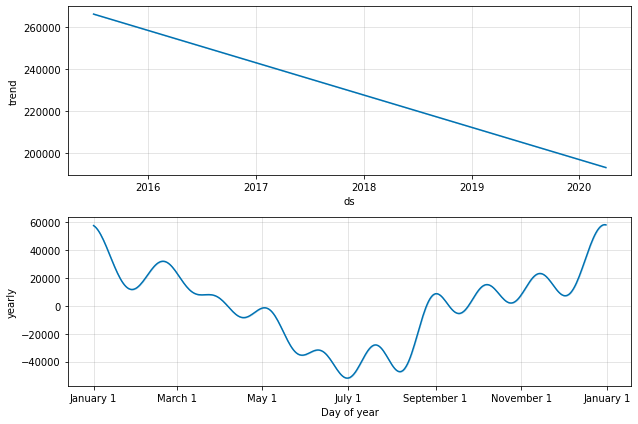

In [12]:
# have a look at your forecast
model.plot(df_forecast).show()

# inspect the model components (trend, saisonalities)
model.plot_components(df_forecast).show()

In [13]:
# How does the forecast dataframe look like? What information can you get out of it?
predicted = df_forecast[-test_len:]
predicted.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
52,2019-10-31,199400.675951,161188.208656,250151.809355,199400.672095,199400.678765,5904.024319,5904.024319,5904.024319,5904.024319,5904.024319,5904.024319,0.0,0.0,0.0,205304.700271
53,2019-11-30,198134.687866,162650.323393,251077.920124,198134.677022,198134.695960,8009.778687,8009.778687,8009.778687,8009.778687,8009.778687,8009.778687,0.0,0.0,0.0,206144.466552
54,2019-12-31,196826.500177,214414.400197,299814.719040,196826.481735,196826.518030,57944.424287,57944.424287,57944.424287,57944.424287,57944.424287,57944.424287,0.0,0.0,0.0,254770.924464
55,2020-01-31,195518.312488,165616.763165,249269.979486,195518.285798,195518.339278,12023.886330,12023.886330,12023.886330,12023.886330,12023.886330,12023.886330,0.0,0.0,0.0,207542.198818
56,2020-02-29,194294.524005,175583.866256,263219.988076,194294.487868,194294.559000,24702.306077,24702.306077,24702.306077,24702.306077,24702.306077,24702.306077,0.0,0.0,0.0,218996.830082


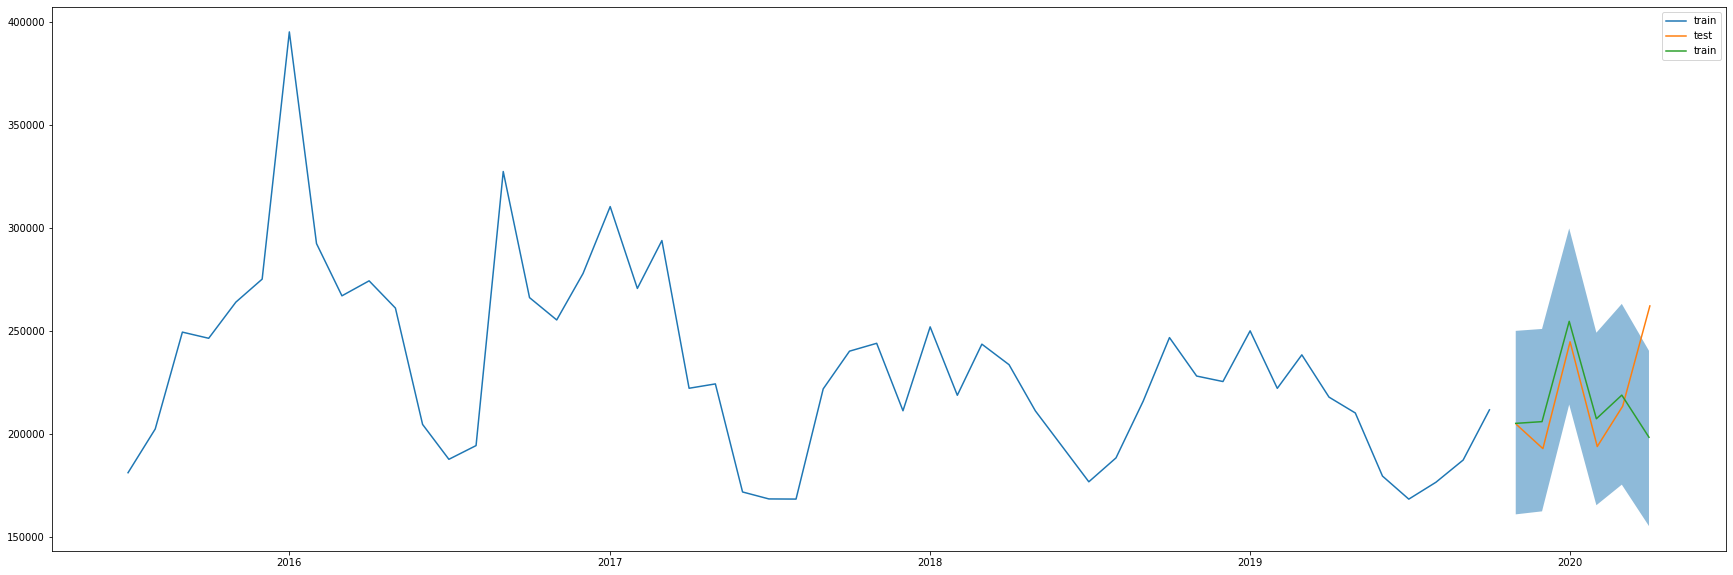

In [14]:
# plot training and test
fig =plt.figure(figsize=(30, 10))
plt.plot(train['ds'], train['y'], label='train')
plt.plot(test['ds'], test['y'], label='test')
plt.plot(predicted['ds'], predicted['yhat'], label='predicted')
plt.fill_between(predicted['ds'], predicted['yhat_lower'], predicted['yhat_upper'], alpha=0.5)
plt.legend()
plt.show()

In [15]:
# Calculate error metrics

print('Error')
print('---')
print('Train')
print('MAE', mean_absolute_error(y_true=train['y'], y_pred=df_forecast[:-test_len]['yhat']))
print('RMSE', mean_squared_error(y_true=train['y'], y_pred=df_forecast[:-test_len]['yhat'], squared=False))
print('-')
print('Test')
print('MAE', mean_absolute_error(y_true=test['y'], y_pred=predicted['yhat']))
print('RMSE', mean_squared_error(y_true=test['y'], y_pred=predicted['yhat'], squared=False))
print('---')

Error
---
Train
MAE 16262.806947493951
RMSE 21809.868569262715
-
Test
MAE 17683.07163569104
RMSE 27490.76996810693
---
